In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys

sys.path.append("..")
from src.utils import (
    plot_cat_grid,
    plot_ordinal_grid,
    plot_correlation_heatmap,
    statistical_testing,
)

In [3]:
df = pd.read_csv("../data/processed/student-clean.csv")
df.columns

Index(['Unnamed: 0', 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus',
       'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime',
       'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3',
       'subject', 'total_alc', 'parent_edu'],
      dtype='object')

# **Question Formualation & Data Analysis**

## **Q1: Các yếu tố về gia đình (như `famsize`, `Medu`, `Fedu`, ...) có ảnh hưởng đến kết quả học tập của một học sinh hay không?**

### **The question**
- Tập trung vào mối quan hệ giữa các biến độc lập thuộc nhóm gia đình (`famsize`, `Pstatus`, `Medu`,...) và biến Target là điểm số cuối kì `G3`

### **Motivation and Benefits**
- Câu hỏi đáng để nghiên cứu: Gia đình là môi trường giáo dục đầu tiên, có ảnh hưởng lớn để sự phát triển của trẻ vị thành niên. Việc xác định những yếu tố về gia đình như tình trạng gia đình, trình độ học vấn của ba mẹ, mối quan hệ của học sinh với gia đình có phải là những yếu tố dựa đoán mạnh mẽ rằng học sinh sẽ học tập tốt hơn hay không.
- Lợi ích và Insight mang lại: 
    - Học vấn của mẹ (Medu) hay của bố (Fedu) có ảnh hưởng lớn hơn đến kết quả học tập của con cái.
    
- Đối tượng quan tâm:
    - Giáo viên, hiệu trưởng: để hiểu rõ hoàn cảnh của học sinh và từ đó có cái nhìn khách quan hơn, và có các phương pháp tiếp cận phù hợp.
    - Bộ giáo dục: có các chính sách để bổ trợ cho các nhóm học sinh yếu thế.

- Vấn đề thực tế có thể được giải quyết: Kết quả phân tích giúp ta xây dựng được các chương trình **Can thiệp sớm**. Thay vì đợi học sinh học yếu đi thì mới hỗ trợ hay chỉ hỗ trợ những học sinh nghèo vượt khó. Ta còn có thể dựa vào các yếu tố về gia đình có thể xác định các học sinh vào nhóm có *nguy cơ cao* ngay từ đầu năm học để cung cấp và hỗ trợ về cố vấn học tập hay tài chính kịp thời.

### **A. Preprocessing**
Các bước preprocessing:
1. Data Preparation: Trích xuất các đặc trưng có liên quan đến gia đình của học sinh $\rightarrow$ dùng để phân tích

2. Feature Engineering:
    - Tạo đặc trưng `parent_edu`: Gồm trung cộng của `Medu` và `Fedu`
    
3. Data Cleaning:
    - Gom nhóm dữ liệu `Medu` và `Fedu` do `Medu = 0` và `Fedu = 0` có số lượng quá ít (không có giá trị thực tiễn) $\rightarrow$ gom nhóm dữ liệu với ` Fedu || Medu = 1`

In [4]:
# Chuẩn bị data cho câu hỏi liên quan
fam_features = ["famsize", "Pstatus", "Medu", "Fedu", "Mjob", "Fjob", "famsup", "famrel", "parent_edu"]

ordinal_features = ["Medu", "Fedu", "famrel", "parent_edu"]

cat_features = [f for f in fam_features if f not in ordinal_features]

# Tạo dataframe chỉ gồm các yếu tố liên quan đến gia đình
df_fam = df[[f"{f}" for f in fam_features]].copy()

# Thêm cột target và dataframe
df_fam['G3'] = df['G3']

In [5]:
# Gộp các giá trị Medu và Fedu = 0 vào mức 1 
df_fam['Medu'] = df_fam['Medu'].replace(0, 1)
df_fam['Fedu'] = df_fam['Fedu'].replace(0, 1)

# Do đã cập nhật nên sẽ liệu quan đến biến parent_edu
df_fam['parent_edu'] = (df_fam['Medu'] + df_fam['Fedu']) / 2

### **B. Analysis**

- **Visualization**: sử dụng **Boxplot** vẽ các cột categorical (so sánh sự phân tán của các cột). Đối với các cột Numerical sẽ vẽ thêm đường trung bình trong **Boxplot**. Và sau cùng là vẽ **Heatmap** để so sánh độ tương quan tổng thể của các biến Numerical (bao gồm cả biến target)

- **Kiểm định thống kê**: để xác thực các quan sát rút ra từ biểu đồ, sử dụng kiểm định **T-test** (cho các cột có biến nhị phân) và **ANOVA** (cho các cột có nhiều biến) với ngưỡng tin cậy là 95%

Boxplot cho các biến categorical

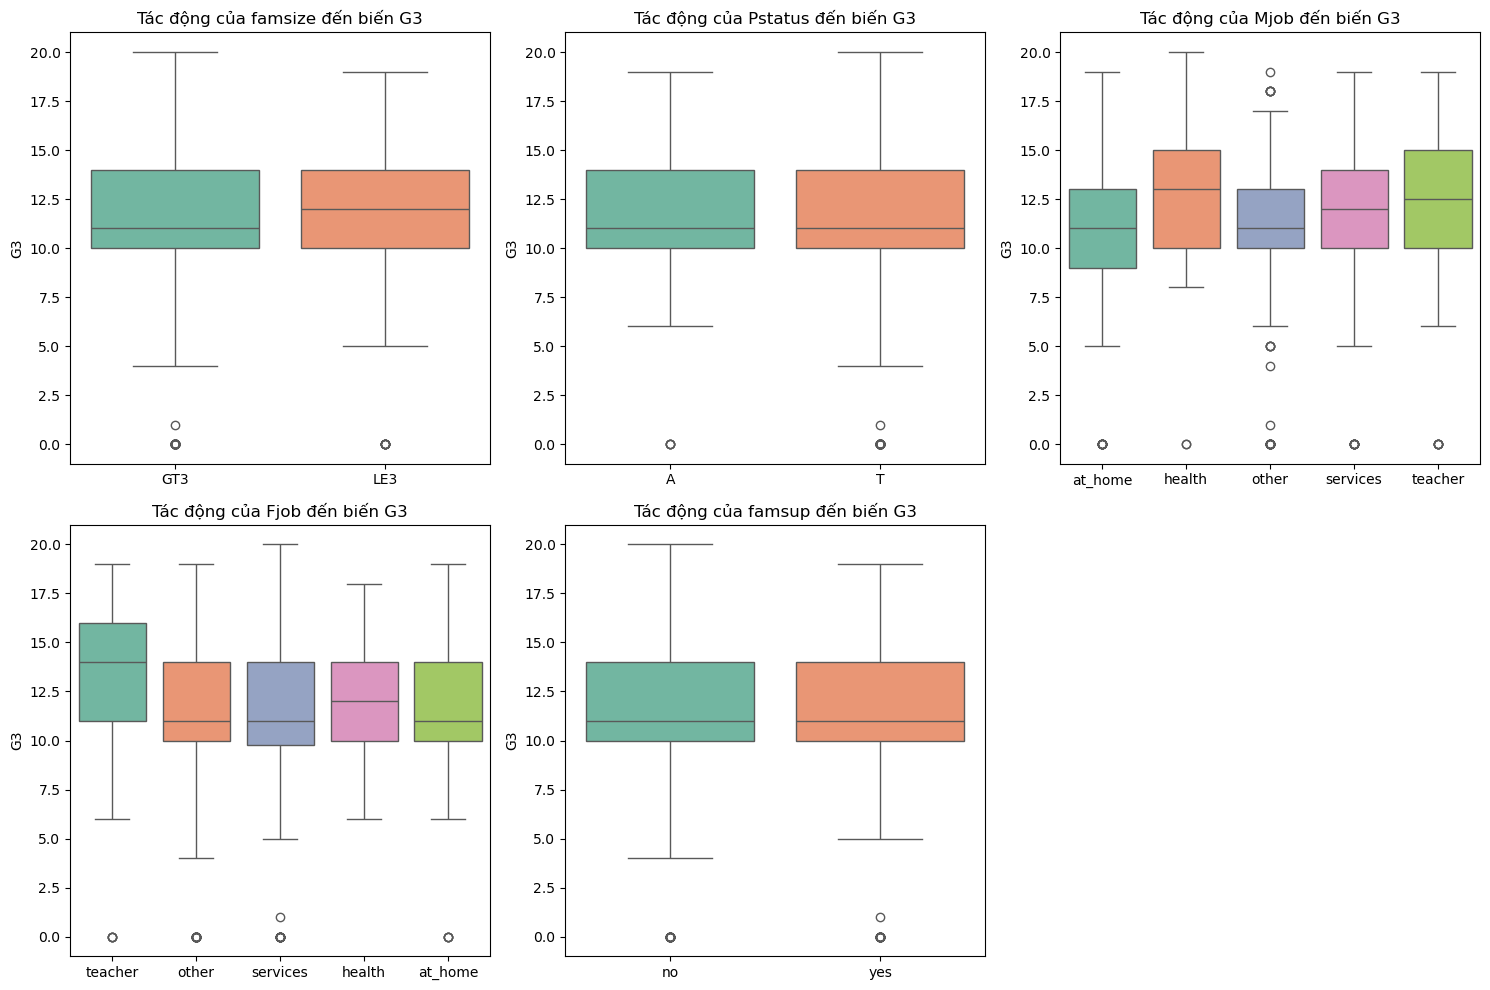

In [7]:
plot_cat_grid(df_fam, cat_features)

Boxplot (có thêm đường trung bình) cho các biến Numerical

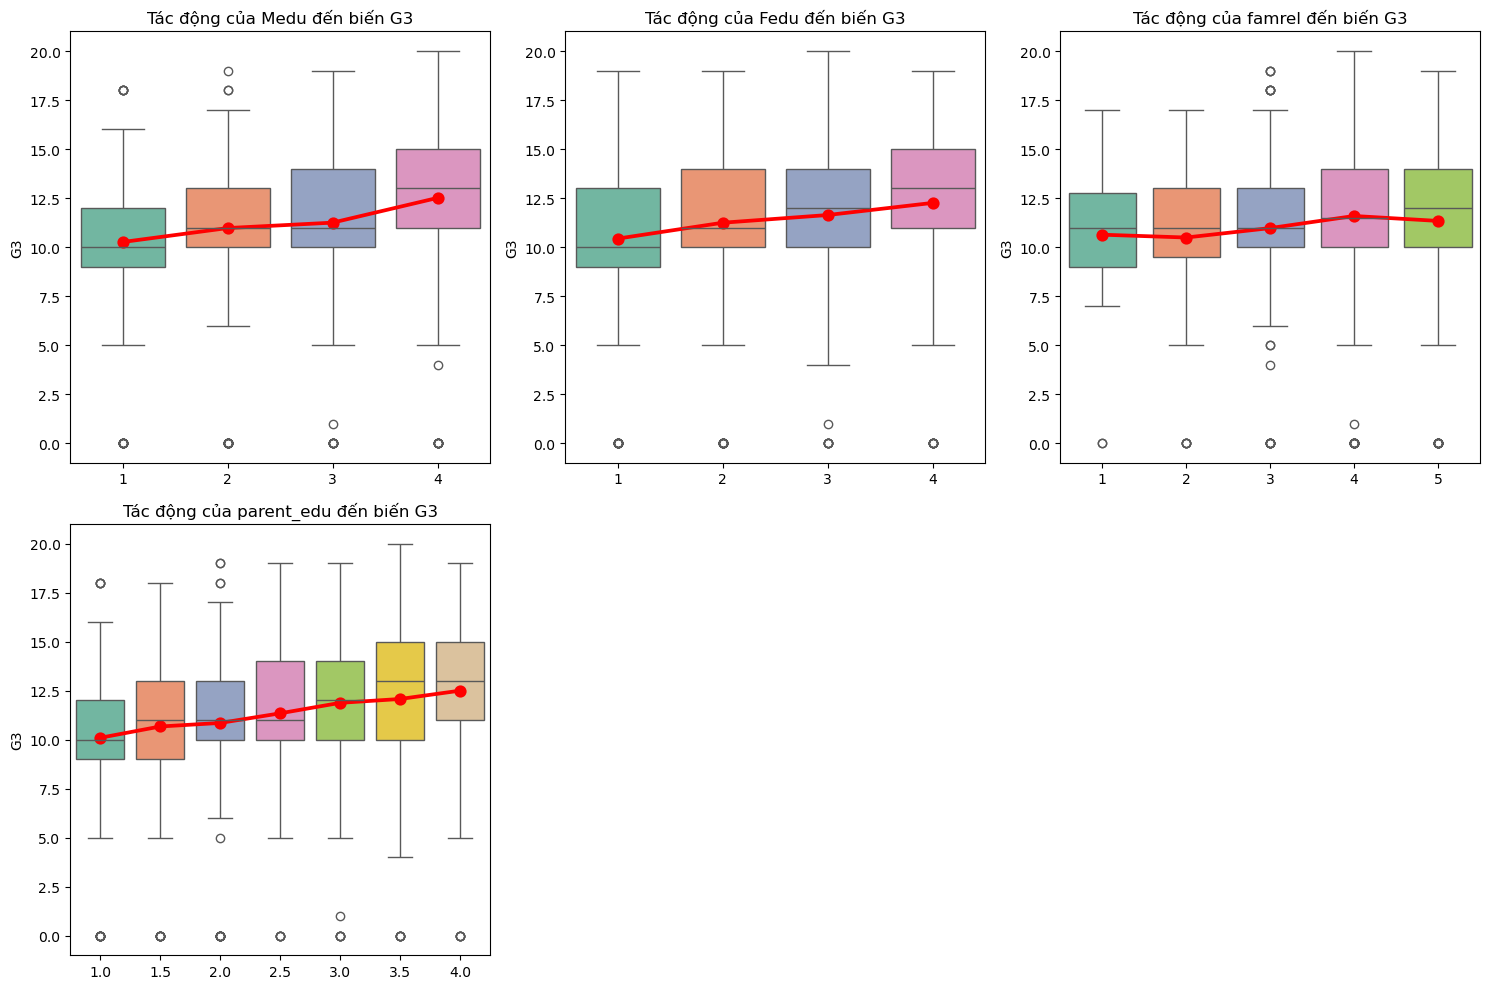

In [8]:
plot_ordinal_grid(df_fam, ordinal_features)

Vẽ correlation heatmap cho các biến Numerical

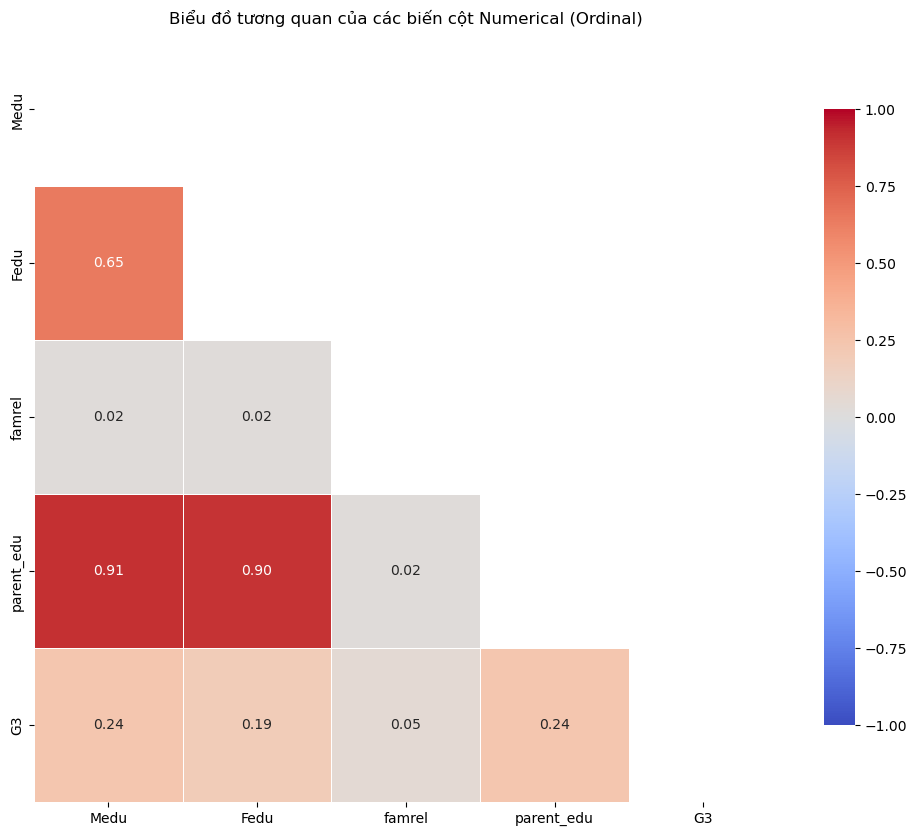

In [9]:
ordinal_with_target = ordinal_features + ['G3']
plot_correlation_heatmap(df_fam, ordinal_with_target)

#### **Thực hiện lại bằng T-test/ANOVA**

In [10]:
# Kiểm tra các biến bằng T-test và ANOVA
affect_features = []
for cat in fam_features:
    if(statistical_testing(df_fam, cat)):
        affect_features.append(cat)

print(affect_features)

--------------------

Kiểm định cột famsize
Loại test: T-test
P-value: 0.048020
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Pstatus
Loại test: T-test
P-value: 0.321797
Không ảnh hưởng (Sự khác biệt chỉ là ngẫu nhiên)

--------------------

Kiểm định cột Medu
Loại test: ANOVA
P-value: 0.000000
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Fedu
Loại test: ANOVA
P-value: 0.000002
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Mjob
Loại test: ANOVA
P-value: 0.000003
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Fjob
Loại test: ANOVA
P-value: 0.009036
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột famsup
Loại test: T-test
P-value: 0.667452
Không ảnh hưởng (Sự khác biệt chỉ là ngẫu nhiên)

--------------------

Kiểm định cột famrel
Loại test: ANOVA
P-value: 0.139367
Không ảnh hưởng (Sự

### **C. Results & Interpretation**

#### **Kết quả nghiên cứu**  

Dựa vào các kết quả phân tích trực quan và kiểm định thống kê, ta có thể khẳng định rằng trong tập dataset này các yếu tố gia đình có ảnh hưởng đáng kể đến kết quả học tập của học sinh. Nhưng các yếu tố ảnh hưởng không đồng đều:  

- Ảnh hưởng mạnh nhất: Nhóm về nền tảng tri thức `parent_edu` (hay `Medu` và `Fedu`) và nghề nghiệp (`Fedu`, `Medu`). 

- Ảnh hưởng tầm trung: Quy mô của gia đình (`famsize`).  

- Các cột còn lại không có ảnh hưởng đáng kể đến kết quả điểm số của học sinh.  

#### **Phân tích chi tiết**  

**1. Tác động của nền tảng tri thức (`parent_edu`)**  
Dựa vào biểu đồ Boxplot và kiểm định ANOVA (p_value = 0.05) ta thấy có 1 xu hướng rõ rệt là, trình độ học vấn của cha mẹ càng cao thì điểm trung bình của con họ càng cao theo.

- Dẫn chứng: Ta thấy khi `parent_edu = 3.5 hay 4.0` thì điểm trung vị đạt khoảng 12.5 điểm, cao hơn đáng kể so với nhóm học sinh có cha mẹ học thấp hơn.

- Ý nghĩa: Điều này cho ta thấy nền tảng tri thức có ảnh hưởng rất nhiều đến nhận thức và là nền tảng cho học sinh có khả năng và phương pháp học tập tốt hơn.

**2. Tác động của nghề nghiệp (`Mjob`, `Fjob`)**  
Nghề nghiệp còn phản ánh môi trường tri thức, thói quen tại gia đình

- Dẫn chứng: Các học sinh có bậc cha mẹ làm giáo viên (`teacher`) hoặc làm trong khối ngành sức khoẻ (`health`) có mức điểm vượt trội hơn các nhóm còn lại.

- Ý nghĩa: Sự chênh lệch này gợi ý rằng sự ổn định về kinh tế và môi trường khuyến học tạo ra lợi thế cạnh tranh lớn cho học sinh.

**3. Tác động quy mô gia đình (`famsize`)**   
Mặc dù nhìn vào Boxplot thấy sự chênh lệch các giá trị không quá lớn, nhưng sau khi kiểm định T-test đã xác định được sự khác biệt về mặc thống kê

- Dẫn chứng: Học sinh có gia đình quy mô nhỏ thì điểm sẽ ổn định hơn các gia đình có quy mô lớn.

- Ý nghĩa: Điều này rất phù hợp với giả thuyết rằng ở một gia đình ít con hơn thì vấn đề tiền bạc hay sự quan tâm đều chất lượng hơn nhiều so với gia đình có đông con (bị chia nhỏ ra nên ít có sự quan tâm hơn)

#### **Những phát hiện trong phân tích dữ liệu**

**1. Nghịch lý trong `famsup`**  
Một điều trái với những suy đoán thông thường (nếu được gia đình ủng hộ nhiều trong việc học tập thì điểm số của học sinh sẽ tốt hơn) nhưng ở đây dù cho có được ủng hộ hay không thì cũng không tạo ra được sự khác biệt về điểm số của 2 nhóm đó.

- Phân tích: Cả 2 nhóm "Được hỗ trợ" và "Không được hỗ trợ" đều có trung vị tương đương với nhau.

- Ý nghĩa: Việc nhóm học sinh "Không được hỗ trợ" có trung vị ngang với nhóm còn lại chứng tỏ việc các em học sinh nhận thức được việc cần phải tự cố gắng học tập cho nên điểm trung vị của 2 bên là xấp xỉ nhau.

**2. Điểm lừa trong `Medu`**  
Dựa vào biểu đồ ta thấy `Medu = 0` có điểm trung vị rất cao có thể ngang với nhóm `Medu = 4`. Nhưng đây chỉ là sự sai lệch do kích thước mẫu quá nhỏ (chiếm <1% bộ dữ liệu) $\rightarrow$ kết quả này không thể hiện được xu hướng chung có thể bỏ qua hoặc gộp với `Medu = 1`

#### **Limitations**
- Tương quan không phải Nhân quả: Việc con giáo viên học giỏi có thể do gen di truyền hoặc môi trường, không chắc chắn 100% là do nghề nghiệp quyết định.

- Dữ liệu vùng miền: Dữ liệu chỉ thu thập tại Bồ Đào Nha, có thể mang các đặc thù văn hóa châu Âu (như việc uống rượu Walc) không áp dụng hoàn toàn cho học sinh Việt Nam.


## **Q2: Dựa vào các thói quen của học sinh để dự đoán họ có trở nên uống rượu nhiều hơn hay không? (sử dụng Machine Learning)**

### **The question**
- Dữ liệu sử dụng sẽ tập trung vào các biến hành vi (thói quen) của học sinh như `goout`, `freetime`,... để sự đoán về biến mục tiêu `total_alc` rằng học sinh đó sẽ được phân loại vô nhóm uống nhiều hay uống ít.

### **Motivation and Benefits**
- Câu hỏi đáng để nghiên cứu: Ta tập trung vào những yếu tố có thể khắc phục, trái với các yếu tố gia đình thì thói quen ta có thể can thiệp và điều chỉnh sao cho hợp lí. Và một phần cũng giúp kiểm chứng được tác động của những thói quen đó có làm cho một người uống rượu nhiều hơn hay không.

- Lợi ích của câu hỏi: 
    - Xác định được những thói quen độc hại nào sẽ có nguy cơ gây uống rượu cao ở học sinh.
    - Dự báo sớm dự trên các hành vi, chỉ cần quan sát trong quá trình sinh hoạt, thói quen có thể dự báo được nguy cơ.

- Đối tượng quan tâm:
    - Phụ huynh: Để họ hiểu rằng các thói quen sinh hoạt cũng rất quan trọng chứ không chỉ là có điểm số.
    - Giáo viên, tư vấn viên: Họ có cơ sở để phát hiện các học sinh có nguy cơ uống rượu cao và từ đó có các cách can thiệp sớm kịp thời.

- Vấn đề thực tế có thể được giải quyết: Giúp nhà trường, phụ huynh phát hiện sớm hành vi để có thể can thiệp kịp thời, tránh những hành vi sa ngã quá mức. Ngoài ra còn có thể thiết kế các chương trình giáo dục kĩ năng, giúp điều chỉnh thói quen hoặc nâng cao nhận thức của học sinh ngay từ sớm để ngăn chặn nguy cơ.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from src.utils import evalutate_model, oversampling_train_data

### **A. Preprocessing**
Các bước preprocessing:
- Trích xuất các feature về thói quen của học sinh và biến target (`total_alc`)

- Encoding: các biến categorical và biến target (thành 0 - Uống ít, 1 - Uống nhiều)


In [12]:
df = pd.read_csv("../data/processed/student-clean.csv")

In [13]:
habit_features = ["studytime", "activities", "internet", "romantic", "freetime", "goout"]

df_habit = df[habit_features].copy()
df_habit['total_alc'] = df['total_alc'].copy()

In [14]:
# Encoding các biến categorical
mapping_binary = {
    'yes' : 1,
    'no' : 0,
}

binary_features = ["activities", "internet", "romantic"]
for f in binary_features:
    df_habit[f] = df_habit[f].map(mapping_binary)

### **B. Analysis**

#### **Vẽ Colleration Heatmap của các biến**

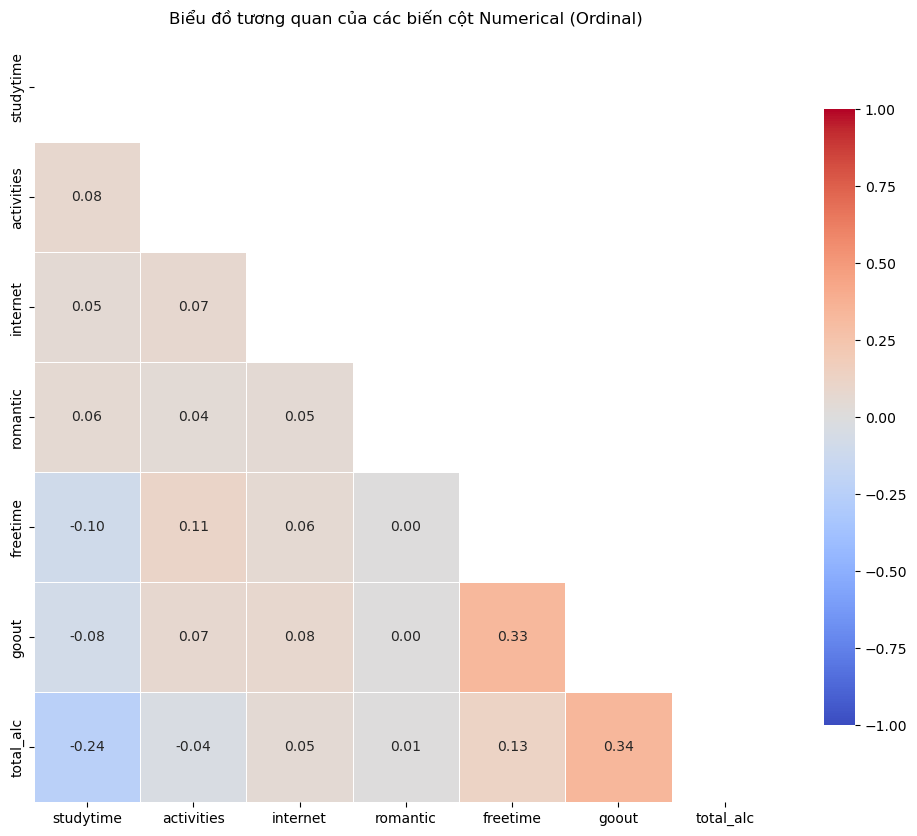

In [15]:
habit_target_features = habit_features + ["total_alc"]

plot_correlation_heatmap(df_habit, habit_target_features)

**Nhận xét:** 
- Nhóm có độ tương quan cao với biến `total_alc`: `goout` (tương quan thuận), `studytime` (tương quan nghịch) $\rightarrow$ Điều đó cho thấy việc càng dành nhiều thời gian để đi chơi sẽ khiến học sinh càng uống rượu nhiều hơn và với việc dành nhiều thời gian để học tương đương với việc uống ít rượu hơn.

- Các nhóm còn lại có tác động không đáng kể.

#### **Kiểm tra biến Target**

In [31]:
df_habit['is_high_risk'] = (df_habit['total_alc'] > 3).astype(int)

df_habit['is_high_risk'].value_counts()

is_high_risk
0    943
1    101
Name: count, dtype: int64

#### **Sử dụng Machine Learning để dự đoán**

In [32]:
# Dữ liệu train
target_col = 'is_high_risk'

X = df_habit[habit_features].copy()
y = df_habit[target_col].copy()


In [33]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 33)

In [34]:
X_train_resample, y_train_resample = oversampling_train_data(X_train, y_train)

In [36]:
# Baseline
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=33)

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

evalutate_model("Logistis Regression", y_test, y_pred_lr)

Model: Logistis Regression
Accuracy: 0.69
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       193
           1       0.15      0.62      0.24        16

    accuracy                           0.69       209
   macro avg       0.55      0.66      0.52       209
weighted avg       0.90      0.69      0.76       209



In [25]:
# RandomForest
rf_model = RandomForestClassifier(class_weight='balanced_subsample', random_state=33, n_estimators=100)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

evalutate_model("Random Forest", y_test, y_pred_rf)

Model: Random Forest
Accuracy: 0.82
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.85      0.90       193
           1       0.18      0.38      0.24        16

    accuracy                           0.82       209
   macro avg       0.56      0.61      0.57       209
weighted avg       0.88      0.82      0.85       209



In [27]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

evalutate_model("SVC", y_test, y_pred_svm)

Model: SVC
Accuracy: 0.70
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.72      0.82       193
           1       0.11      0.44      0.18        16

    accuracy                           0.70       209
   macro avg       0.53      0.58      0.50       209
weighted avg       0.88      0.70      0.77       209



### **C. Results & Interpretation**